<a href="https://colab.research.google.com/github/Ananthzeke/Deep-Learning/blob/main/Gender_Prediction_using_2D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
import numpy as np


In [ ]:
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

dataset = tf.keras.utils.get_file(
    "wiki_crop", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset), 'wiki_crop')

811327488/811315200 [==============================] - 30s 0us/step


In [ ]:
import scipy.io
# extract data from wiki.mat
mat = scipy.io.loadmat(os.path.join(dataset_dir,'wiki.mat'))

In [ ]:
if True in np.isnan(mat['wiki']['gender'][0][0][0]):
  print(True)


True


In [ ]:
mat['wiki']['gender'][0][0][0]

array([1., 1., 1., ..., 1., 1., 0.])

In [ ]:
mat["wiki"]["full_path"][0][0][0]

array([array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
       array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
       array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
       array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
       array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
       array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')],
      dtype=object)

In [ ]:
Nan_removed_indices=np.where(np.isnan(mat['wiki']['gender'][0][0][0])==False)[0]

In [ ]:
gender=mat['wiki']['gender'][0][0][0][Nan_removed_indices]

In [ ]:
if True not  in np.isnan(gender):print('Removed Null values')
 

Removed Null values


In [ ]:
file_path = np.vectorize(lambda x : os.path.join(dataset_dir,x[0]))(
    mat["wiki"]["full_path"][0][0][0][Nan_removed_indices]
)

In [ ]:
file_path

array(['./wiki_crop/17/10000217_1981-05-05_2009.jpg',
       './wiki_crop/48/10000548_1925-04-04_1964.jpg',
       './wiki_crop/12/100012_1948-07-03_2008.jpg', ...,
       './wiki_crop/09/9998109_1972-12-27_2013.jpg',
       './wiki_crop/00/9999400_1981-12-13_2011.jpg',
       './wiki_crop/80/999980_1954-06-11_2008.jpg'], dtype='<U49')

In [ ]:
file_gender_ds=tf.data.Dataset.from_tensor_slices((file_path,gender))

In [ ]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels=1)
    image = tf.image.resize(image_decoded, [256, 256])/256
    return image, tf.expand_dims(label,0)

In [ ]:
image_gender_ds = file_gender_ds.map(parse_function).shuffle(seed=2,buffer_size=64)


In [ ]:
dataset_size = image_gender_ds.cardinality().numpy()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = image_gender_ds.take(dataset_size*.6).batch(128).prefetch(AUTOTUNE)
val_ds = image_gender_ds.skip(dataset_size*.6).take(dataset_size*.2).batch(128).prefetch(AUTOTUNE)
test_ds = image_gender_ds.skip(dataset_size*.8).take(dataset_size*.2).batch(128).prefetch(AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
model = tf.keras.Sequential([
    tfl.Conv2D(32,(5,5),padding="same",activation="relu",input_shape=(256,256,1)),
    tfl.MaxPool2D((4,4),strides = 2),
    tfl.Conv2D(32,(5,5),padding = "valid",activation="relu"),
    tfl.MaxPool2D((4,4),strides = 4),
    tfl.Conv2D(64,(5,5),padding = "valid",activation="relu"),
    tfl.MaxPool2D((4,4),strides = 2),
    tfl.Conv2D(128,(3,3),padding= "valid",activation="relu",),
    tfl.MaxPool2D((2,2),strides = 2),
    tfl.Conv2D(256,(1,1),padding= "valid",activation="relu",),
    tfl.MaxPool2D((2,2),strides = 2),
    tfl.Flatten(),
    tfl.Dense(64,activation="relu"),
    tfl.Dense(1)                             
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [ ]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10

)

Epoch 1/10
280/280 [==============================] - 80s 285ms/step - loss: 0.1990 - accuracy: 0.9242 - val_loss: 0.3875 - val_accuracy: 0.8682
Epoch 2/10
280/280 [==============================] - 77s 276ms/step - loss: 0.1804 - accuracy: 0.9331 - val_loss: 0.3638 - val_accuracy: 0.8704
Epoch 3/10
280/280 [==============================] - 78s 277ms/step - loss: 0.1764 - accuracy: 0.9337 - val_loss: 0.3996 - val_accuracy: 0.8717
Epoch 4/10
280/280 [==============================] - 77s 276ms/step - loss: 0.1706 - accuracy: 0.9335 - val_loss: 0.4198 - val_accuracy: 0.8795
Epoch 5/10
280/280 [==============================] - 78s 277ms/step - loss: 0.1589 - accuracy: 0.9408 - val_loss: 0.4845 - val_accuracy: 0.8754
Epoch 6/10
280/280 [==============================] - 78s 278ms/step - loss: 0.1506 - accuracy: 0.9431 - val_loss: 0.4936 - val_accuracy: 0.8812
Epoch 7/10
280/280 [==============================] - 78s 278ms/step - loss: 0.1404 - accuracy: 0.9483 - val_loss: 0.5371 - val_ac

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

94/94 [==============================] - 35s 101ms/step - loss: 0.5121 - accuracy: 0.8644
Loss:  0.5121160745620728
Accuracy:  0.8643712997436523


In [ ]:
import matplotlib.pyplot as plt 
history = history.history


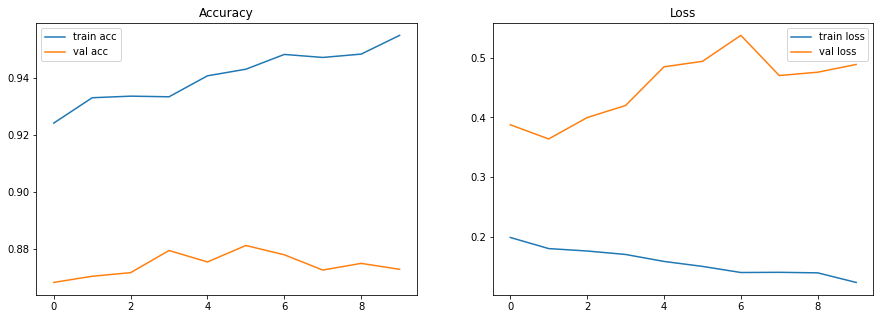

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()
